In [2]:
import numpy as np
import scipy.linalg as splin
from scipy.integrate import LSODA, solve_ivp
import matplotlib.pyplot as plt

from consts import *
from lyapunov import *
from pac import *
from potential import *
from lyap_obj import *

In [3]:
# Initial conditions (alpha0) and Jacobi interval
alpha0 = 50/384400 # initial guess for alpha

# C = 2U(r) - (vx^2 + vy^2)
C_range = [3.1370, 3.1493]

In [3]:
fL1 = Family(XL1, mu)
fL1.find_family(alpha0, 40)

In [4]:
fL2 = Family(XL2, mu)
fL2.find_family(alpha0, 40)

In [6]:
fL1.plot_family()
fL2.plot_family()

AttributeError: 'LyapOrbit' object has no attribute 'compute_orbit'

In [ ]:
# Obtain two orbits in [C_range[0]  C_range[1]] in L1
orbsL1 = find_Crange(fL1, 2, C_range, verbose=True)

Found 1 orbits in the range, PACing to find more
Found orbit 1
ds: 0.01, C_guess: 3.1422696744783893, G_guess: 5.476330919737421e-13


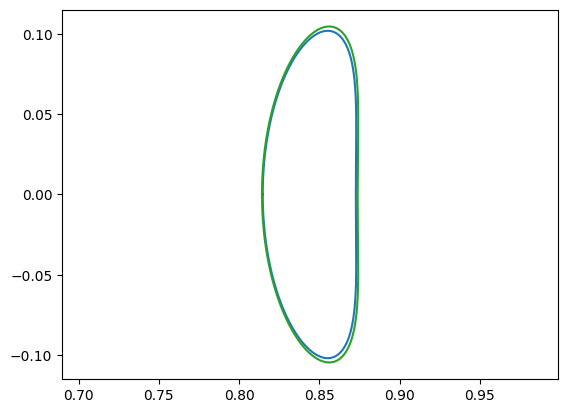

In [ ]:
for orbit in orbsL1:
    orbit.plot()
plt.axis('equal')
plt.show()

In [ ]:
# Find isoenergetic L2 orbits
isoC_L2 = []
for oL1 in orbsL1:
    isoC_L2.append(find_isoC(oL1, fL2, verbose=True)) 

Finding orbits with C = 3.1443992162204353
Orbit not in the C tolerance. C = 3.1433196599646114, err = 0.0010795562558238991, ds = -0.02904363630642024, G = 8.331699617969406e-13
Orbit not in the C tolerance. C = 3.1493193248151883, err = 0.004920108594753003, ds = 0.026403305733109308, G = 7.875477799008922e-13
Orbit not in the C tolerance. C = 3.143834479639619, err = 0.0005647365808161275, ds = -0.02400300521191755, G = 9.328671161431607e-13
Orbit not in the C tolerance. C = 3.1487985219467762, err = 0.004399305726340952, ds = 0.021820913829015954, G = 9.897267102174298e-13
Orbit not in the C tolerance. C = 3.1442650029547394, err = 0.00013421326569584835, ds = -0.019837194390014502, G = 7.902185644224434e-13
Orbit not in the C tolerance. C = 3.1483709929316586, err = 0.003971776711223285, ds = 0.018033813081831364, G = 8.209064130835645e-13
Orbit not in the C tolerance. C = 3.144624193000467, err = 0.00022497678003174926, ds = 0.0163943755289376, G = 8.91800706304798e-13
Orbit not 

In [ ]:
# Save the orbits to a file 


In [ ]:
# Orbits are contained in 
# orbsL1
# isoC_L2
# For good measure, set C of the orbits with a e-4 accuracy
for i in range(len(orbsL1)):
    # Truncate to 4 decimal places without rounding
    C = np.round(orbsL1[i].C, 4)
    orbsL1[i].C = C
    isoC_L2[i].C = C
    

In [ ]:
for i in range(len(orbsL1)):
    print(f"Orbit {i+1}")
    print(f"L1: {orbsL1[i].C}")
    print(f"L2: {isoC_L2[i].C}")

Orbit 1
L1: 3.1444
L2: 3.1444
Orbit 2
L1: 3.1423
L2: 3.1423


In [ ]:
# Take a pair of isoenergetic orbits and propagate them for a period T.
# Then, take a point in the interval and compute the eigenvectors and eigenvalues
# of the STM on that point.

# Once this is done, we have Es, Eu, Ec1, Ec2
#### STABLE MANIFOLD
# Inizialize an orbit in x = p + de*Es/|Es| and propagate backwards for a period T 

#### UNSTABLE MANIFOLD
# Inizialize an orbit in x = p + de*Eu/|Eu| and propagate forward for a period

# de = 40/384400
de = 40/384400

In [ ]:
def compute_manifold(orbit: LyapOrbit, n_curves = 10):

    # Computes the stable and unstable manifolds of a given orbit
    
    # Perturbation parameter
    de = 40/384400

    # Compute the periodic orbit
    X, PHI = orbit.propagate()
    PHI = PHI.reshape(4,4)
    # Compute the length of the orbit
    length = len(X[0,:])
    
    T = orbit.T
    mu = orbit.mu
    sol_s = []
    sol_u = []

    for i in range(n_curves):
        p = X[:,i*length//n_curves]
        PHI_p = PHI[:,:,i*length//n_curves]

        assert spli.det(PHI_p) < 1e-10

         # Compute the eigenvectors and eigenvalues of the STM
        eigvals, eigvecs = splin.eig(PHI_p)

        # Compute the stable and unstable eigenvectors
        # E is stable if Re(eigval) < 1 and unstable if Re(eigval) > 1
        Es_idx = [i for i in range(len(eigvals)) if np.abs(eigvals[i]) < 1 and eigvals[i].imag == 0]
        Eu_idx = [i for i in range(len(eigvals)) if np.abs(eigvals[i]) > 1 and eigvals[i].imag == 0]

        # Take eigenvalues and eigenvectors
        Es, EVs = eigvals[Es_idx], eigvecs[:, Es_idx]
        Eu, EVu = eigvals[Eu_idx], eigvecs[:, Eu_idx]

        ### Compute deviation vectors
        # Stable
        X_s = p + de*EVs[:,0]/np.linalg.norm(EVs[:2,0])
        # Unstable
        X_u = p = de*EVu[:,0]/np.linalg.norm(EVu[:2,0])


        

        ### Propagate the deviation vectors
        # Build the initial conditions
        PHI0 = np.zeros((4,4))
        X0s = np.concatenate((X_s, PHI0.flatten()))
        X0u = np.concatenate((X_u, PHI0.flatten()))
        
        
        
        # Stable (backwards)
        sol_s = solve_ivp(fdyn, [0, -T], X0s,t_eval= np.linspace(0, -T, 1000),
                           method='LSODA', args=(T, mu), rtol=1e-12, atol=3e-12)
        # Unstable (forward)
        sol_u = solve_ivp(fdyn, [0, T],X0u, t_eval= np.linspace(0,T, 1000),
                          method='LSODA', args=(T, mu), rtol=3e-12, atol=1e-12)

        # Extract the solution
        Xs = sol_s.y[:4,:]
        Xu = sol_u.y[:4,:]

        sol_s.append(Xs)
        sol_u.append(Xu)
    # End of loop

    return sol_s, sol_u









In [ ]:
sol_s, sol_u = compute_manifold(orbsL1[0], 10)

In [ ]:
# Plot the manifolds
fig, ax = plt.subplots()
for i in range(10):
    ax.plot(sol_s[i][0,:], sol_s[i][1,:], 'b')
    ax.plot(sol_u[i][0,:], sol_u[i][1,:], 'r')
